# Implementation of Mini-Batch Stochastic Gradient Descent for Linear Regression

I used Pytorch as well as numpy and pandas to solve a basic linear regression problem using my own implementation of mini-batch stochastic gradient descent, as defined by Google [here](https://developers.google.com/machine-learning/crash-course/reducing-loss/stochastic-gradient-descent).

The dataset was found on Kaggle, and can be accessed at this [link](https://www.kaggle.com/venjktry/simple-linear-regression).

## Initial Setup
I imported all the libraries I was using for this task, as well as animation capabilities from matplotlib so I could animate the gradient descent. Furthermore, I set a parameter for the mini-batch size I wanted to use, and also set a random seed so that the outputs will remain the same every time the code is run.

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch

from matplotlib import animation, rc
rc('animation', html='jshtml')

In [0]:
minibatch_size = 10
np.random.seed(minibatch_size)

## Setting Up the Data
I used pandas to import the data from the two csv files, and make sure that no values were missing. After that, I converted the columns into Pytorch tensors which I can use for gradient descent. I also added a column of ones into the X data to be used as a bias column.

In [147]:
train_data = pd.read_csv('/content/train.csv')
train_data.head()

,x,y
0,24,21.549452
1,50,47.464463
2,15,17.218656
3,38,36.586398
4,87,87.288984


In [148]:
test_data = pd.read_csv('/content/test.csv')
test_data.head()

,x,y
0,77,79.775152
1,21,23.177279
2,22,25.609262
3,20,17.857388
4,36,41.849864


In [149]:
train_data.isnull().values.any()

False

In [150]:
test_data.isnull().values.any()

False

In [0]:
x_train = torch.tensor(train_data['x'].to_numpy(), dtype=torch.double)
y_train = torch.tensor(train_data['y'].to_numpy())
x_test = torch.tensor(test_data['x'].to_numpy(), dtype=torch.double)
y_test = torch.tensor(test_data['y'].to_numpy())

In [152]:
X_train = torch.stack((x_train, torch.ones(x_train.size()[0], dtype=torch.double)), 1); X_train[:5]

tensor([[24.,  1.],
        [50.,  1.],
        [15.,  1.],
        [38.,  1.],
        [87.,  1.]], dtype=torch.float64)

In [153]:
X_test = torch.stack((x_test, torch.ones(x_test.size()[0], dtype=torch.double)), 1); X_test[:5]

tensor([[77.,  1.],
        [21.,  1.],
        [22.,  1.],
        [20.,  1.],
        [36.,  1.]], dtype=torch.float64)

In [154]:
num_features = X_train.size()[1]; num_features

2

In [155]:
num_examples = X_train.size()[0]; num_examples

700

## Implementing Gradient Descent
In order to implement gradient descent, I split the task up into functions. The `cost` function calculates the mean squared error between the hypothesis and the actual data, and the `update` function is what get repeatedly called to update the values of the parameter theta in order to minimize the cost.

In [0]:
def cost(h, y): 
  return ((h - y)**2).mean()

In the `update` function, the cost (and therefore gradient) are only calculated based on a few randomly selected values of `X_train` and `y_train` - ie. calculating the gradient descent based on mini-batches.

`error.backward()` calls a Pytorch function that computes the gradient of the error for each element of every tensor that it depends on, and then accumulates it in the `.grad` member of each of those tensors. This needs to be cleared back to zero after every step, or else it will continue accumulating. That is why `theta.grad` needs to be set to zero at the end of each update cycle. 

Since Pytorch doesn't allow you to modify tensors while it's tracking their gradient, `theta` and `theta.grad` can only be modified while the gradient isn't being tracked. That's why those two steps are done under a `with` statement where Pytorch's automatic gradient tracking is temporarily disabled.

In [0]:
def update(lr, rand_idx):
    h = X_train[rand_idx]@theta
    error = cost(h, y_train[rand_idx])
    error.backward()
    with torch.no_grad():
      theta.sub_(lr * theta.grad)
      theta.grad.zero_()

The initial values of `theta` are randomly generated using Pytorch.

In [0]:
theta = nn.Parameter(torch.tensor([torch.rand(num_features - 1), 0], dtype=torch.double))

In order to animate the gradient descent, I created a plot of the initial training data, and the initial hypothesis based on the randomly generated values of `theta`. 

The `animate` function essentially just calls the `update` function with a specified learning rate and random indices used for operating on mini-batches. Afterwards, it updates the hypothesis line with new y-values based on the updated hypothesis. It is called 100 times, and each graph it generates is plotted on the animation with a delay of 75 milliseconds.

In [171]:
fig = plt.figure()
plt.scatter(X_train[:,0], y_train)
line, = plt.plot(X_train[:,0], X_train@theta, c='orange')
plt.close()

def animate(i):
    lr = 1e-5
    rand_idx = torch.tensor(np.random.randint(low = 0, high = num_examples, size = minibatch_size))
    update(lr, rand_idx)
    line.set_ydata(X_train@theta)
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=75)

## Evaluation of Performance
Here, I decided to compare my implementation of linear regression using mini-bacth stochastic gradient descent with the implementation of linear regression provided by the popular machine learning library Scikit-learn.

First, I displayed the parameters I trained, and plotted the predictions they made against both the training and test datasets. I also displayed the respective errors on both datasets.

In [172]:
theta

Parameter containing:
tensor([0.9986, 0.0043], dtype=torch.float64, requires_grad=True)

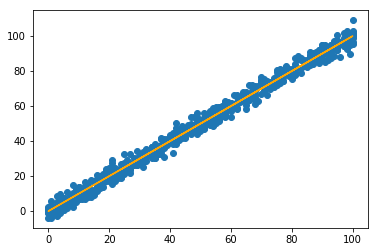

In [173]:
h = X_train@theta
plt.scatter(X_train[:,0], y_train)
line, = plt.plot(X_train[:,0], X_train@theta, c='orange')

In [174]:
error_rate_train = cost(y_train, h); error_rate_train

tensor(7.8930, dtype=torch.float64, grad_fn=<MeanBackward0>)

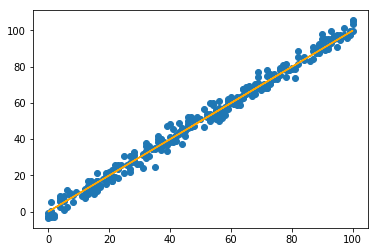

In [175]:
plt.scatter(X_test[:,0], y_test)
line, = plt.plot(X_test[:,0], X_test@theta, c='orange')

In [176]:
error_rate_test = cost(y_test, X_test@theta); error_rate_test

tensor(9.4780, dtype=torch.float64, grad_fn=<MeanBackward0>)

Afterwards, I made a quick implementation of linear regression using the scikit-learn library, and plotted its performance against the test set. Although the scikit-learn implementation was better, as I expected, it was only by very little (the error of the scikit-learn model on the test set was approximately 9.37, which was only around 0.11 lower than the error of my model on the test set).

In [177]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
params = torch.tensor(reg.coef_, dtype=torch.double)
error_rate_scikit = cost(y_test, X_test@params); error_rate_scikit

tensor(9.3654, dtype=torch.float64)

In [178]:
params

tensor([1.0008, 0.0000], dtype=torch.float64)

On a graphical plot, the two lines were so similar as to be nearly indistinguishable.

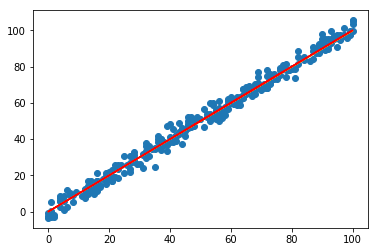

In [179]:
plt.scatter(X_test[:,0], y_test)
line, = plt.plot(X_test[:,0], X_test@theta, c='orange')
line_sci, = plt.plot(X_test[:,0], X_test@params, c='red')

Overall, I'm confident that my implementation of mini-batch stochastic gradient descent was a good one, as it performed extremely similarily to one of the most popular and widely used library implementations.